In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window, visualize_score_map
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor
from matcher import CnnMatcher, Window
from image import load_image
from feature_extractor import CNN, ReCNN, ResizeImageFeatureExtractor, FeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer, Scorer
from shape.basic import Size
from utils.timer import timer

def visualize_result(img: np.ndarray, score_map: np.ndarray, threshold: float, rois: Candidates, best_window: Window, scores: torch.Tensor):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img)
    axes[1].imshow(score_map)
    axes[2].imshow(score_map > threshold)

    windows = rois.rois.cpu().numpy()
    best_pos_indices = (windows[:, 1] == best_window.cx) & (windows[:, 2] == best_window.cy)
    best_pos_windows = windows[best_pos_indices]
    best_pos_scores = scores.reshape(-1)[best_pos_indices].cpu().numpy()
    angles = best_pos_windows[:, 5]
    axes[3].plot(angles, best_pos_scores)
    axes[3].set_xlabel('angle')
    axes[3].set_ylabel('score')
    axes[3].set_ylim(0.0, 1.0)
    plt.show()

Text(0.5, 1.0, 'template')

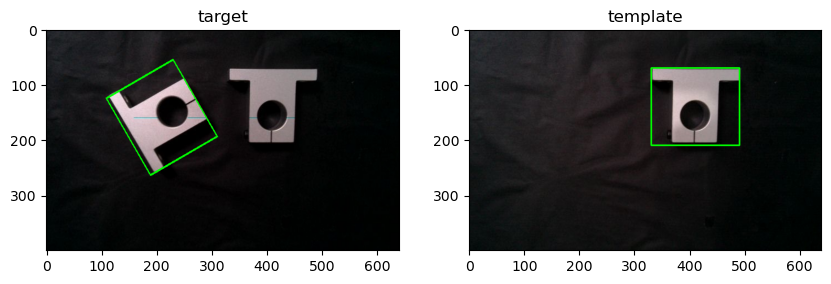

In [2]:
target_img = load_image('../data/image_1.png')
template_img = load_image('../data/template_1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

target_window = Window(210, 160, 160, 140, -120)
draw_img = draw_window(target_img, target_window)
axes[0].imshow(draw_img)
axes[0].set_title('target')

template_window = Window(410., 140., 160., 140., 0)
draw_img = draw_window(template_img, template_window)
axes[1].imshow(draw_img)
axes[1].set_title('template')

In [3]:
target_image_size = Size(*target_img.shape[:2])
template_size = template_window.get_size()
scales = [2, 4, 8, 16]

In [4]:
def evaluate(feature_extractor: FeatureExtractor, roi_feature_extractor: RoIAlignFeatureExtractor, scorer: Scorer, angle_step: int = 5):
    with timer('calc_cnn1'):
        template_feature_maps = feature_extractor(template_img)
    with timer('calc_cnn2'):
        target_feature_maps = feature_extractor(target_img)

    for idx, scale in enumerate(scales):
        rois = Candidates(template_size, target_image_size, angle_step=angle_step, x_step=scale, y_step=scale)
        with timer('calc_roi_features'):
            roi_features = roi_feature_extractor.extract(target_feature_maps[idx], rois.rois, spatial_scale=1.0/scale)

        template_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scale)
        # template_features = roi_feature_extractor.extract(target_feature_maps[idx], target_window, spatial_scale=1.0/scale)

        with timer('calc_scores'):
            scores = scorer.score(template_features, roi_features)
        best_score = scores.max()
        best_score_index = scores.argmax()

        num_steps = rois.get_num_steps()
        scores = scores.reshape(num_steps.y, num_steps.x, num_steps.angle)
        score_map = scores.max(-1).values.cpu().numpy()

        best_window = Window.from_array(rois[best_score_index])
        draw_img = draw_window(target_img, best_window)

        print(f'best score: {best_score:.4f} at {best_window}')
        visualize_result(draw_img, score_map, 0.8, rois, best_window, scores)

# CNN

Elapsed time for calc_cnn1           : 0.0219
Elapsed time for calc_cnn2           : 0.0010
Elapsed time for calc_roi_features   : 13.7549
Elapsed time for calc_scores         : 0.7946
best score: 0.9953 at Window(cx=410.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


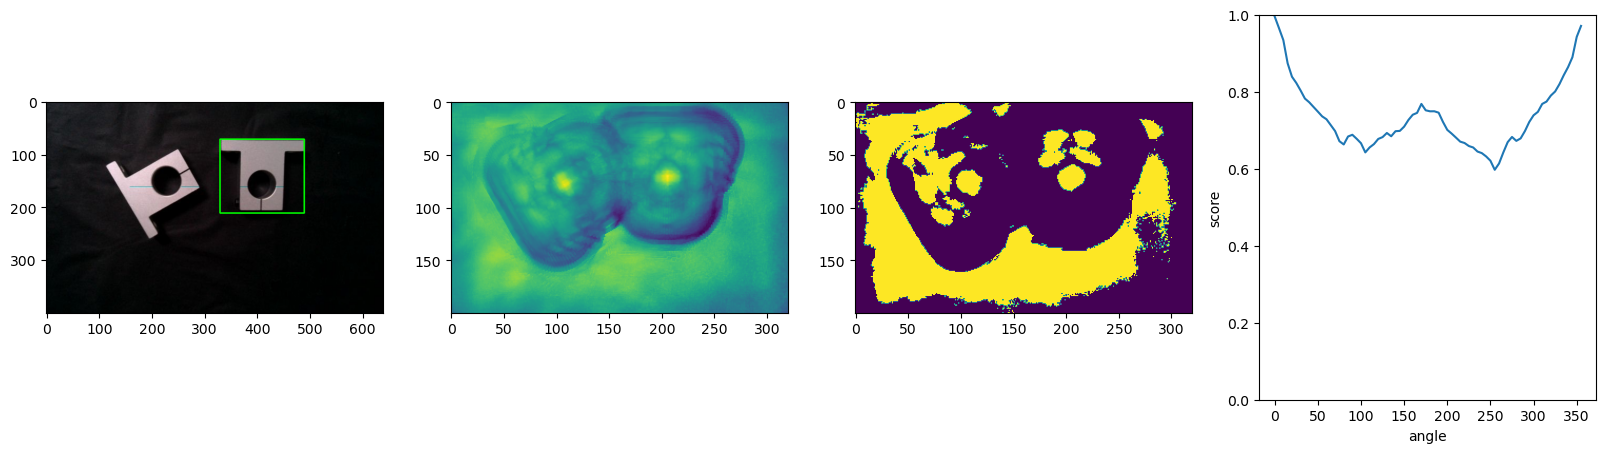

Elapsed time for calc_roi_features   : 3.3398
Elapsed time for calc_scores         : 0.1893
best score: 0.9879 at Window(cx=412.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


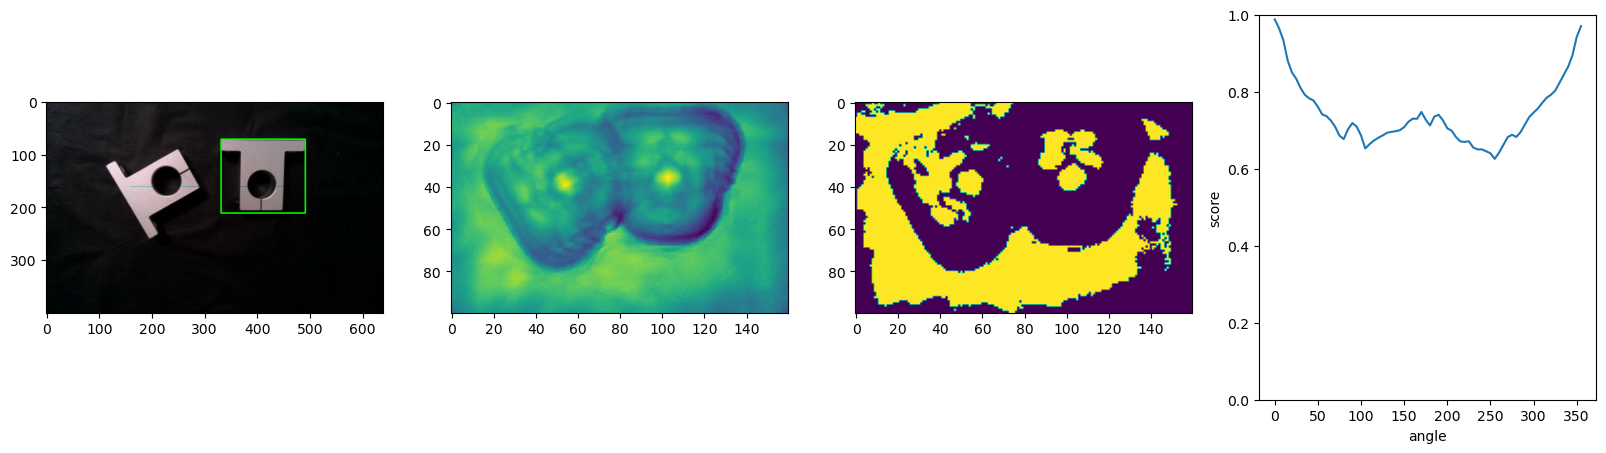

Elapsed time for calc_roi_features   : 0.8224
Elapsed time for calc_scores         : 0.0500
best score: 0.9848 at Window(cx=408.0, cy=136.0, width=160.0, height=140.0, angle=0.0)


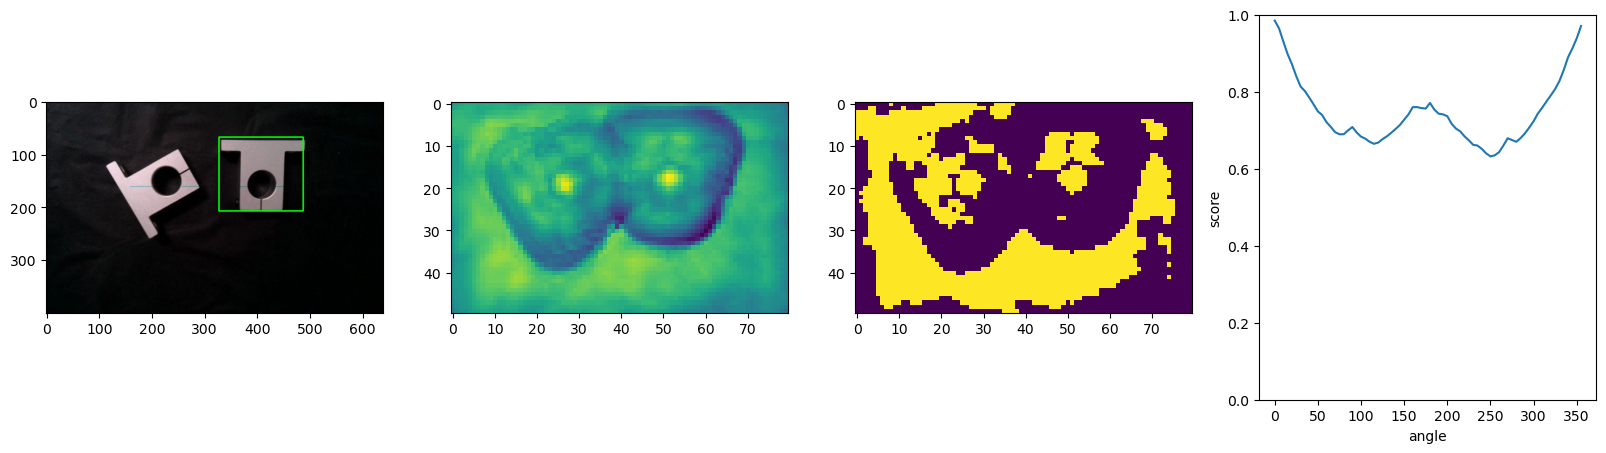

Elapsed time for calc_roi_features   : 0.2114
Elapsed time for calc_scores         : 0.0123
best score: 0.9620 at Window(cx=416.0, cy=144.0, width=160.0, height=140.0, angle=0.0)


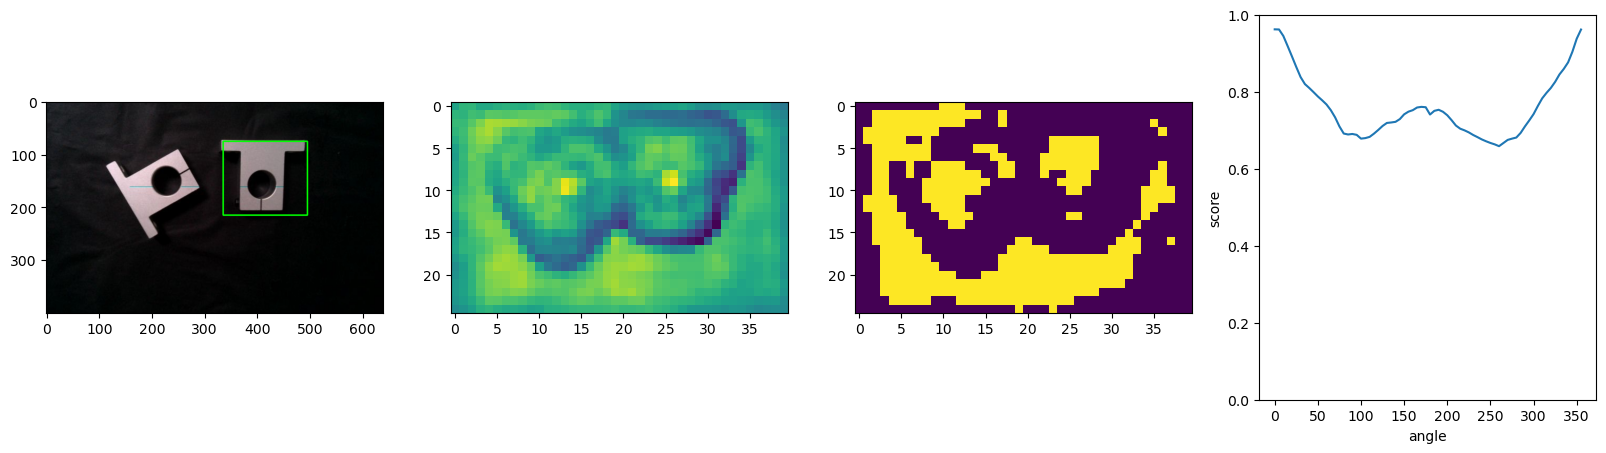

In [5]:
from feature_extractor import ResizeImageFeatureExtractor

feature_extractor = ResizeImageFeatureExtractor()
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=7, sampling_ratio=2)
scorer = CosineSimilarityScorer()
evaluate(feature_extractor, roi_feature_extractor, scorer, angle_step=5)

In [6]:
device='cuda'
feature_extractor = CNN(device=device, pretrained=True)
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2, device=device)
scorer = CosineSimilarityScorer()
evaluate(feature_extractor, roi_feature_extractor, scorer)

Elapsed time for calc_cnn1           : 0.6940
Elapsed time for calc_cnn2           : 0.0085
Elapsed time for calc_roi_features   : 0.1775
Elapsed time for calc_scores         : 0.0209


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.47 GiB (GPU 0; 10.76 GiB total capacity; 2.51 GiB already allocated; 1.05 GiB free; 2.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF